# Homework 5: Photometric reverberation mapping

<span style="color:red">**Deadline:** </span> 07. June 2024. at 1PM

# Task 1

**Goal:**

- Understand the photometric reverberation mapping method and its limitations. 
- Introduction to the tools for simulating AGN light curves and performing photoRM.

<span style="color:blue">**a)**</span> Familiarize yourself with photRM module (read the docs located in photRM.py). Using the `lc_two_bands` function from the `photRM` module, construct **three pairs** of continuum and emission line light curves of length 5000 days. This is a hypothetical scenario where we generate pairs of light curves as if they are observed in two broadband filters:

   - one covering only continuum emission (we will name it *x-band*)
   - second covering emission line and the underlying continuum (we will name it *y-band*)

Make sure that the light curve pairs are simulated for the artificial AGN objects at z = 0.1 having luminosity (log L): 43, 44, and 45, respectively. The emission line contribution to the total integrated flux should be 25% and the continuum contribution 75% in all cases. Plot the first 1000 days of the light curves and compare the properties (printed when you run `lc_two_bands`) of these three simulated AGN objects. How would you explain the correlation between AGN luminosity and broad line region dimensions (i.e. time-lag)? Cut the light curve length to 1000 points and save them for later use.

<span style="color:blue">**b)**</span> Using the photometric reverberation mapping method and the `pyzdcf` module, estimate the time-lag (broad line region radius) for these three light curve pairs. You can use the default values for keyword arguments in the function. How do the time-lag estimates compare to the values reported by `lc_two_bands`? You can estimate the time-lag using the `photRM.peak_finder` or (optionally) you can compile a Fortran code [PLIKE](https://www.weizmann.ac.il/particle/tal/research-activities/software) to obtain more accurate results and errors. Similarly display the results as in Astro Data Lab notebook.

>To install pyzdcf:
>
>   `pip install pyzdcf`
>    
>or you can run this notebook in Astro Data Lab where `pyzdcf` is already installed.

> To run PLIKE:
>
> - download the source code [here](https://webhome.weizmann.ac.il/home/tal/zdcf/plike_v4.0.f90)
> - if you don't have a fortran compiler, I suggest you install `gfortran` on your system
> - navigate to the folder containing the downloaded file
> - from there, run the following commands in the terminal:  
> `gfortran -o plike source_code_filename`  
> `./plike`

<span style="color:blue">**c) (optional)**</span> Now, to reflect a real-world scenario, let's make one of these three pairs of simulated light curves gappier (e.g., the one with log(L) = 44). Alter the light curves so they have the following cadences:

- one observation every 5 days
- one months of observations every day, then one month pause. Repeat the pattern.
- three month of observations every day, followed by six months of observations with a frequency of once per month and then a gap of three months. Repeat the pattern.

Estimate the time-lag from these three pairs of light curves. Write your conclusions regarding the accuracy of time-lag retrieval for different observing strategies you implemented. The light curves should not be longer than 1000 days.

###  Answer (a)

It seems that AGN luminosity positivelt corresponds to time 

In [1]:
# Standard lib
import os
import warnings

# 3rd party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from antares_client.search import search

# Custom libs
import photRM
from pyzdcf import pyzdcf

plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')

In [2]:
xband1_df, yband1_df, zband1_df = photRM.lc_two_bands(5000, z=0.1, lum=43, wl=0.25, wc=0.75)
xband2_df, yband2_df, zband2_df = photRM.lc_two_bands(5000, z=0.1, lum=44, wl=0.25, wc=0.75)
xband3_df, yband3_df, zband3_df = photRM.lc_two_bands(5000, z=0.1, lum=45, wl=0.25, wc=0.75)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 43.00
MBH = 3.14e+06 M_sun
tau_DRW = 17.31 days
sigma_DRW = 0.05 mag^2/day
Time-lag = 9.86 days
Properties of the simulated AGN object:
---------------------------------------
log(L) = 44.00
MBH = 1.46e+07 M_sun
tau_DRW = 31.98 days
sigma_DRW = 0.03 mag^2/day
Time-lag = 33.65 days
Properties of the simulated AGN object:
---------------------------------------
log(L) = 45.00
MBH = 6.76e+07 M_sun
tau_DRW = 59.10 days
sigma_DRW = 0.01 mag^2/day
Time-lag = 114.82 days


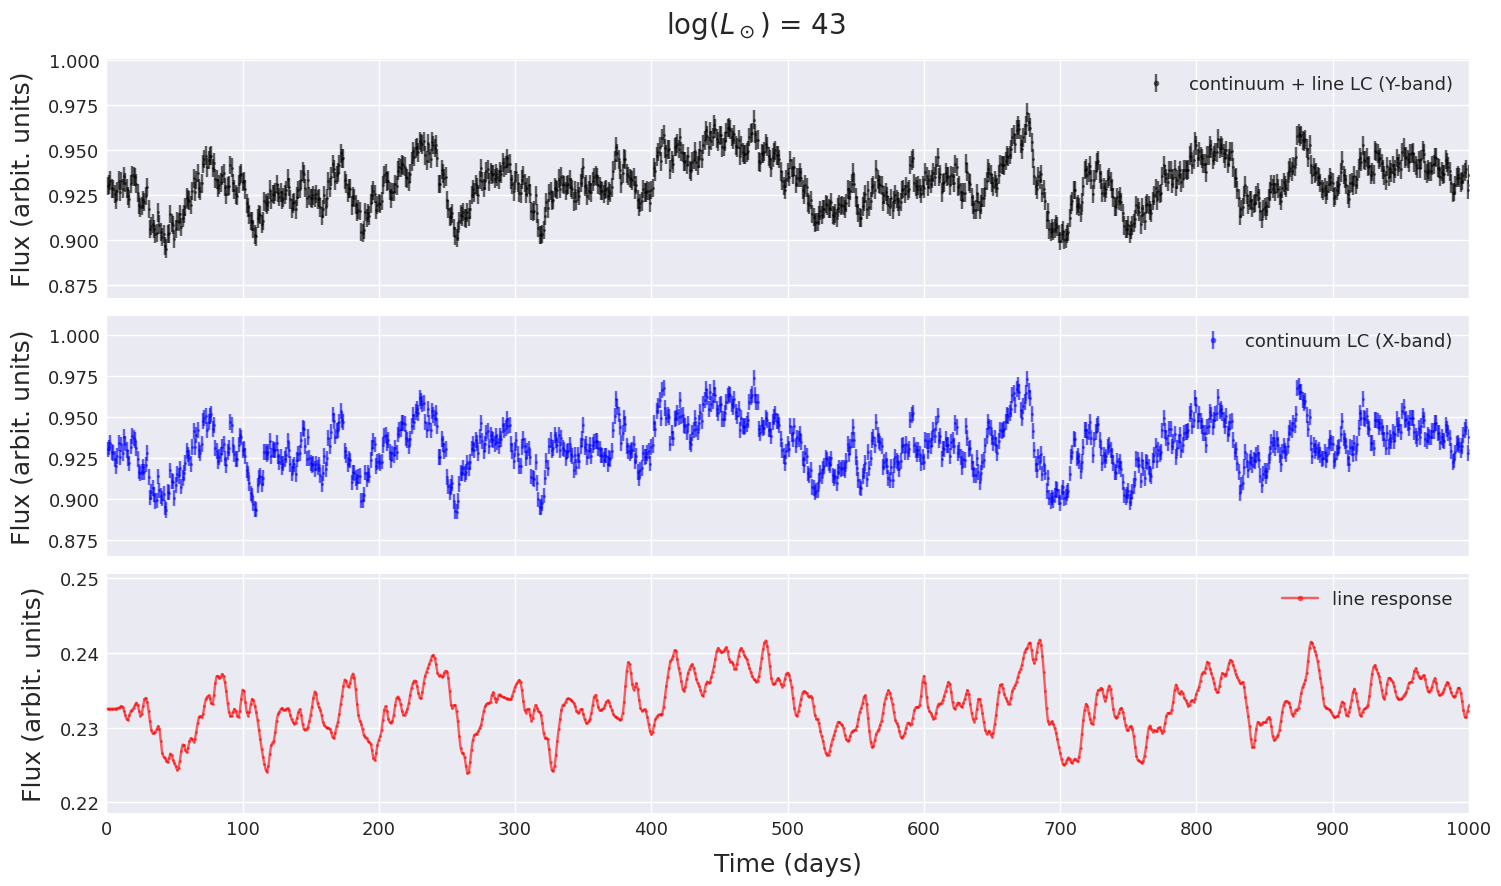

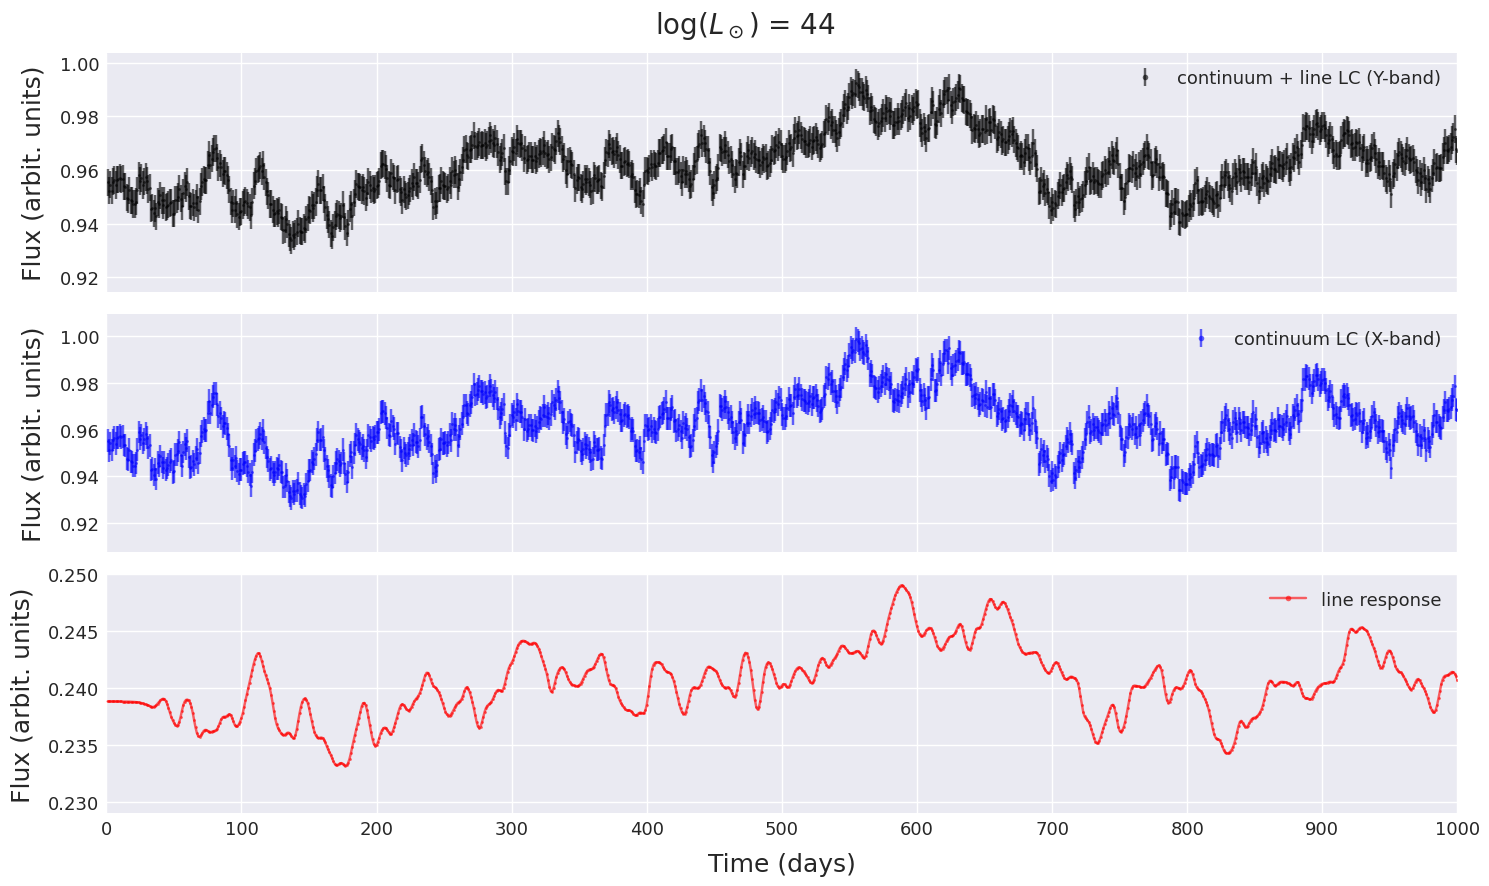

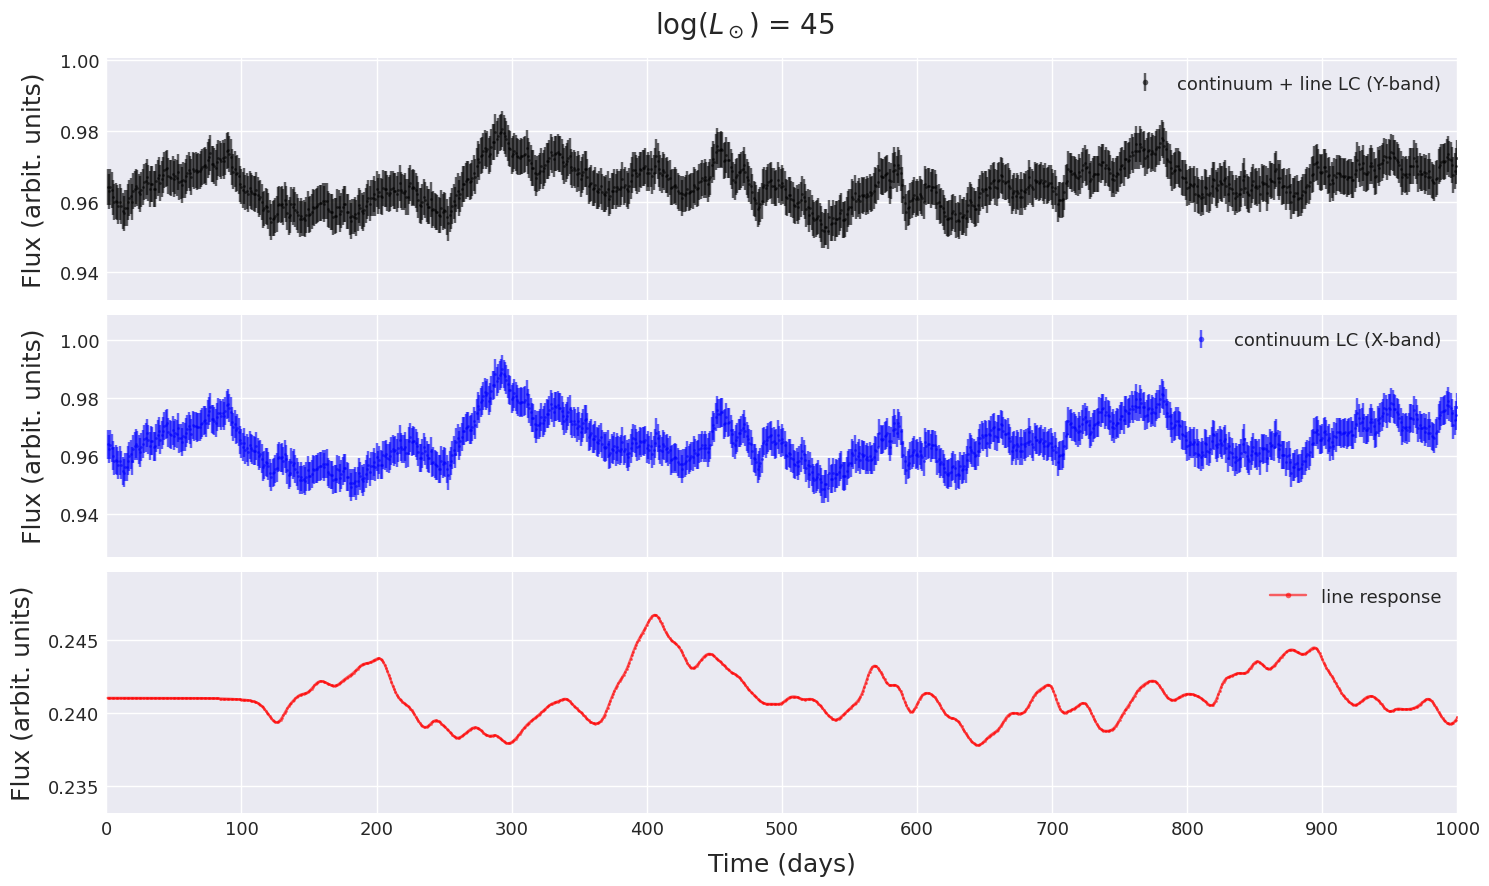

In [3]:
dfs = [[xband1_df, yband1_df, zband1_df], [xband2_df, yband2_df, zband2_df], [xband3_df, yband3_df, zband3_df]]
lums = [43, 44, 45]
# Plot the light curves
for curves, lum in zip(dfs, lums):
    x_band, y_band, line_response = curves

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
    ax1.errorbar(y_band['t'],y_band['flux'],yerr=y_band['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
    ax2.errorbar(x_band['t'],x_band['flux'],yerr=x_band['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
    ax3.plot(line_response['t'], line_response['flux'],'ro-', markersize=2,alpha=0.6, label='line response')
    
    loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals
    
    for ax in [ax1,ax2,ax3]:
        ax.legend(fontsize=13,markerscale=2)
        ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
        ax.tick_params(direction='in',pad=5,labelsize=13)
        ax.set_xlim(0,1000)
        ax.xaxis.set_major_locator(loc)
    
    ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
    fig.suptitle('$\\log(L_\\odot)$ = {}'.format(lum), size=20) # or plt.suptitle('Main title')
    plt.show()

Let's save our data.

In [4]:
# Save the data
dir_path = './data/'
cut = 1000

for curves, lum in zip(dfs, lums):
    x_band, y_band, line_response = curves
    
    np.savetxt(dir_path+'x_band_lum{}'.format(lum), np.c_[x_band.t[:cut],x_band.flux[:cut],x_band.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
    np.savetxt(dir_path+'y_band_lum{}'.format(lum), np.c_[y_band.t[:cut],y_band.flux[:cut],y_band.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
    np.savetxt(dir_path+'response_curve_lum{}'.format(lum) ,np.c_[y_band.t[:cut],y_band.flux[:cut],y_band.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

### Answer (b)

In [5]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc_names = [['x_band_lum43', 'y_band_lum43', 'response_curve_lum43'], ['x_band_lum44', 'y_band_lum44', 'response_curve_lum44'], ['x_band_lum45', 'y_band_lum45', 'response_curve_lum45']]

In [6]:
from pyzdcf import pyzdcf

# Step 2: ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params_1 = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
                prefix            = 'acf_lum43',  # Output files prefix
                uniform_sampling  =  False, # Uniform sampling?
                omit_zero_lags    =  True,  # Omit zero lag points?
                minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
                num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
                lc1_name          =  lc_names[0][0]    # Name of the light curve file
               )

params_2 = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
                prefix            = 'acf_lum44',  # Output files prefix
                uniform_sampling  =  False, # Uniform sampling?
                omit_zero_lags    =  True,  # Omit zero lag points?
                minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
                num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
                lc1_name          =  lc_names[1][0]    # Name of the light curve file
               )

params_3 = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
                prefix            = 'acf_lum45',  # Output files prefix
                uniform_sampling  =  False, # Uniform sampling?
                omit_zero_lags    =  True,  # Omit zero lag points?
                minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
                num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
                lc1_name          =  lc_names[2][0]    # Name of the light curve file
               )

# Run pyzdcf
acf_1 = pyzdcf(input_dir, output_dir, intr=False, parameters=params_1, sep=' ', sparse='auto')
acf_2 = pyzdcf(input_dir, output_dir, intr=False, parameters=params_2, sep=' ', sparse='auto')
acf_3 = pyzdcf(input_dir, output_dir, intr=False, parameters=params_3, sep=' ', sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf_lum43.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf_lum44.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependen

In [7]:
# Step 3: CCF calculation
params_1 = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
                prefix            = 'ccf_lum43',  # Output files prefix
                uniform_sampling  =  False, # Uniform sampling?
                omit_zero_lags    =  True,  # Omit zero lag points?
                minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
                num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
                lc1_name          =  lc_names[0][0],   # Name of the first light curve file
                lc2_name          =  lc_names[0][1]    # Name of the second light curve file
                )

params_2 = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
                prefix            = 'ccf_lum44',  # Output files prefix
                uniform_sampling  =  False, # Uniform sampling?
                omit_zero_lags    =  True,  # Omit zero lag points?
                minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
                num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
                lc1_name          =  lc_names[1][0],   # Name of the first light curve file
                lc2_name          =  lc_names[1][1]    # Name of the second light curve file
                )

params_3 = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
                prefix            = 'ccf_lum45',  # Output files prefix
                uniform_sampling  =  False, # Uniform sampling?
                omit_zero_lags    =  True,  # Omit zero lag points?
                minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
                num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
                lc1_name          =  lc_names[2][0],   # Name of the first light curve file
                lc2_name          =  lc_names[2][1]    # Name of the second light curve file
                )

ccf_1 = pyzdcf(input_dir, output_dir, intr=False, parameters=params_1, sep=' ', sparse='auto')
ccf_2 = pyzdcf(input_dir, output_dir, intr=False, parameters=params_2, sep=' ', sparse='auto')
ccf_3 = pyzdcf(input_dir, output_dir, intr=False, parameters=params_3, sep=' ', sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf_lum43.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf_lum44.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter

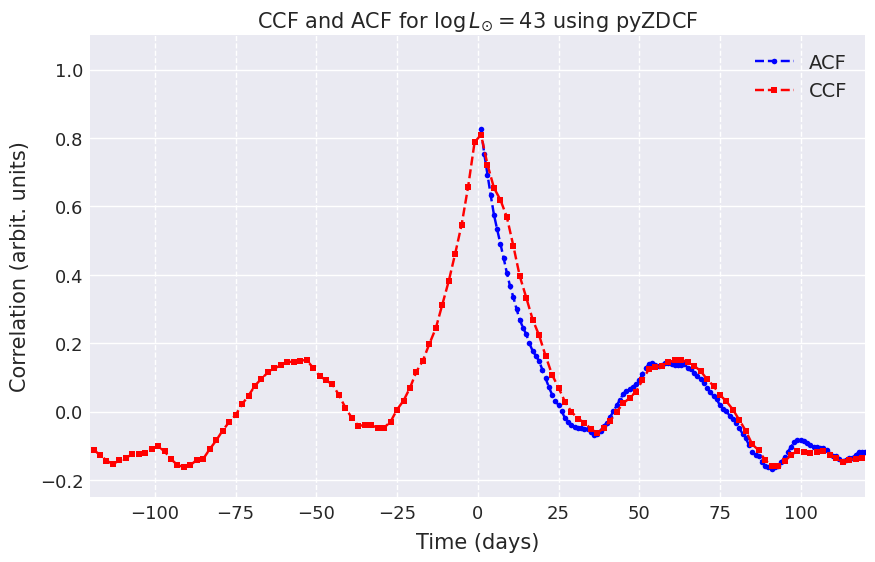

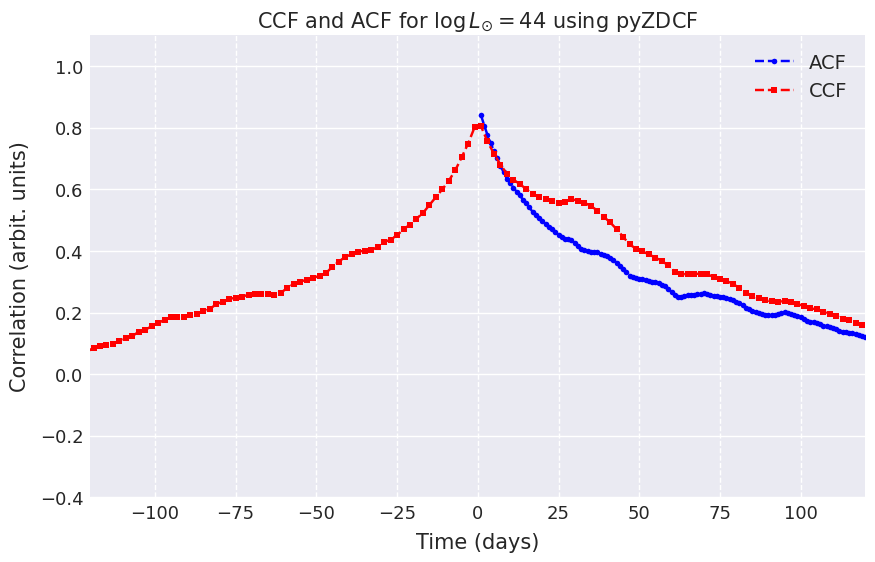

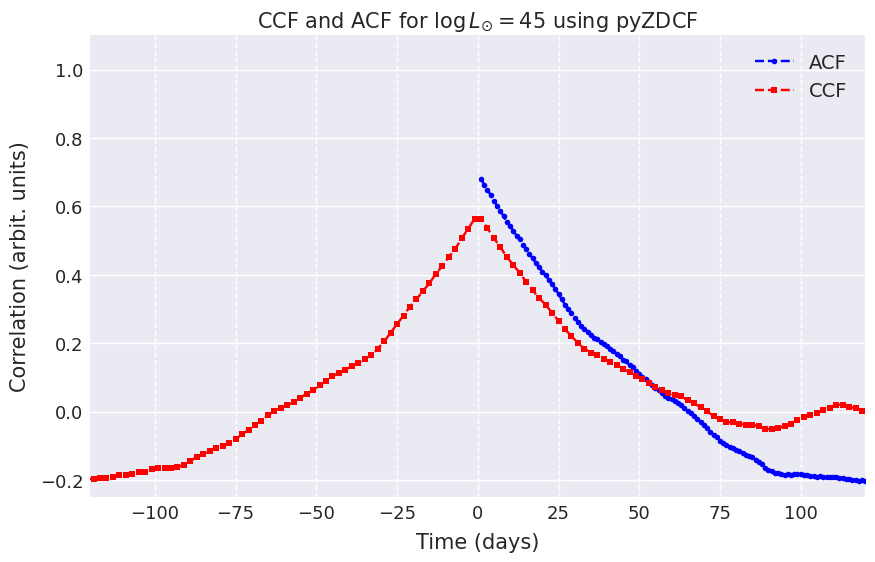

In [8]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_1['tau'], acf_1['dcf'],'o--b', label='ACF', markersize=4)
ax.plot(ccf_1['tau'], ccf_1['dcf'],'s--r', label='CCF', markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF for $\\log{L_{\\odot}} = 43$ using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_2['tau'], acf_2['dcf'],'o--b', label='ACF', markersize=4)
ax.plot(ccf_2['tau'], ccf_2['dcf'],'s--r', label='CCF', markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.4,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF for $\\log{L_{\\odot}} = 44$ using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_3['tau'], acf_3['dcf'],'o--b', label='ACF', markersize=4)
ax.plot(ccf_3['tau'], ccf_3['dcf'],'s--r', label='CCF', markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF for $\\log{L_{\\odot}} = 45$ using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

Calculating the $CCF(\tau)$

In [9]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf_1 = photRM.add_inverted_acf(acf_1)
acf_2 = photRM.add_inverted_acf(acf_2)
acf_3 = photRM.add_inverted_acf(acf_3)


print('ACF shape for $\\log{L_{\\odot}} = 43$: ', acf_1.shape)
print('CCF shape for $\\log{L_{\\odot}} = 43$: ', ccf_1.shape, '\n')

print('ACF shape for $\\log{L_{\\odot}} = 44$: ', acf_2.shape)
print('CCF shape for $\\log{L_{\\odot}} = 44$: ', ccf_2.shape, '\n')

print('ACF shape for $\\log{L_{\\odot}} = 45$: ', acf_3.shape)
print('CCF shape for $\\log{L_{\\odot}} = 45$: ', ccf_3.shape)

ACF shape for $\log{L_{\odot}} = 43$:  (1980, 7)
CCF shape for $\log{L_{\odot}} = 43$:  (992, 7) 

ACF shape for $\log{L_{\odot}} = 44$:  (1980, 7)
CCF shape for $\log{L_{\odot}} = 44$:  (992, 7) 

ACF shape for $\log{L_{\odot}} = 45$:  (1980, 7)
CCF shape for $\log{L_{\odot}} = 45$:  (992, 7)


In [10]:
acf_1 = photRM.interp(ccf_1, acf_1)
acf_2 = photRM.interp(ccf_2, acf_2)
acf_3 = photRM.interp(ccf_3, acf_3)

print('ACF shape for $\\log{L_{\\odot}} = 43$: ',acf_1.shape)
print('CCF shape for $\\log{L_{\\odot}} = 43$: ',ccf_1.shape, '\n')

print('ACF shape for $\\log{L_{\\odot}} = 44$: ',acf_2.shape)
print('CCF shape for $\\log{L_{\\odot}} = 44$: ',ccf_2.shape, '\n')

print('ACF shape for $\\log{L_{\\odot}} = 45$: ',acf_3.shape)
print('CCF shape for $\\log{L_{\\odot}} = 45$: ',ccf_3.shape)

ACF shape for $\log{L_{\odot}} = 43$:  (992, 7)
CCF shape for $\log{L_{\odot}} = 43$:  (992, 7) 

ACF shape for $\log{L_{\odot}} = 44$:  (992, 7)
CCF shape for $\log{L_{\odot}} = 44$:  (992, 7) 

ACF shape for $\log{L_{\odot}} = 45$:  (992, 7)
CCF shape for $\log{L_{\odot}} = 45$:  (992, 7)


In [11]:
# Subtracting CCF and ACF
final_ccf_1 = photRM.delta_ccf(acf_1, ccf_1)
final_ccf_2 = photRM.delta_ccf(acf_2, ccf_2)
final_ccf_3 = photRM.delta_ccf(acf_3, ccf_3)

In [12]:
tau_1, peaks_x1, peaks_y1 = photRM.peak_finder(final_ccf_1.dcf.values, final_ccf_1.tau.values, (0,200))
tau_2, peaks_x2, peaks_y2 = photRM.peak_finder(final_ccf_2.dcf.values, final_ccf_2.tau.values, (0,200))
tau_3, peaks_x3, peaks_y3 = photRM.peak_finder(final_ccf_3.dcf.values, final_ccf_3.tau.values, (0,200))

err_low_1 = final_ccf_1.loc[final_ccf_1.tau == tau_1, '-sig(tau)'].values[0]
err_high_1 = final_ccf_1.loc[final_ccf_1.tau == tau_1, '+sig(tau)'].values[0]

err_low_2 = final_ccf_2.loc[final_ccf_2.tau == tau_2, '-sig(tau)'].values[0]
err_high_2 = final_ccf_2.loc[final_ccf_2.tau == tau_2, '+sig(tau)'].values[0]

err_low_3 = final_ccf_3.loc[final_ccf_3.tau == tau_3, '-sig(tau)'].values[0]
err_high_3 = final_ccf_3.loc[final_ccf_3.tau == tau_3, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [  9.  75. 109. 157. 169. 173. 185.]
Max. peak:  9.0
Peak candidates (x-axis vals):  [ 33.  61.  83. 107. 131. 143. 153. 179.]
Max. peak:  33.0
Peak candidates (x-axis vals):  [113.]
Max. peak:  113.0


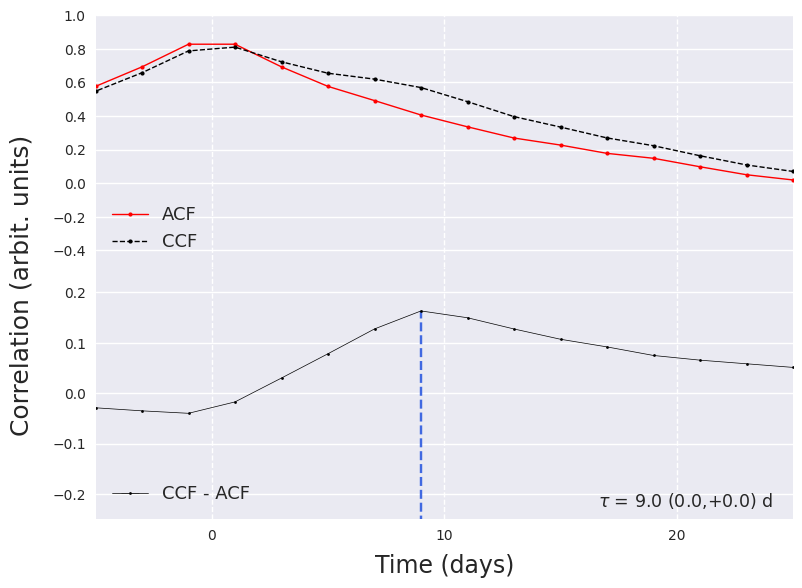

In [13]:
lims_x1 = (-5, 25)
lims_y1 = (-0.5, 1)
err_1 = (err_low_1*(-1), err_high_1)

photRM.plot_ccf_acf(final_ccf_1, ccf_1, acf_1, locator=10, peak=True, tau=tau_1, err=err_1, lims_x=lims_x1, lims_y=lims_y1)

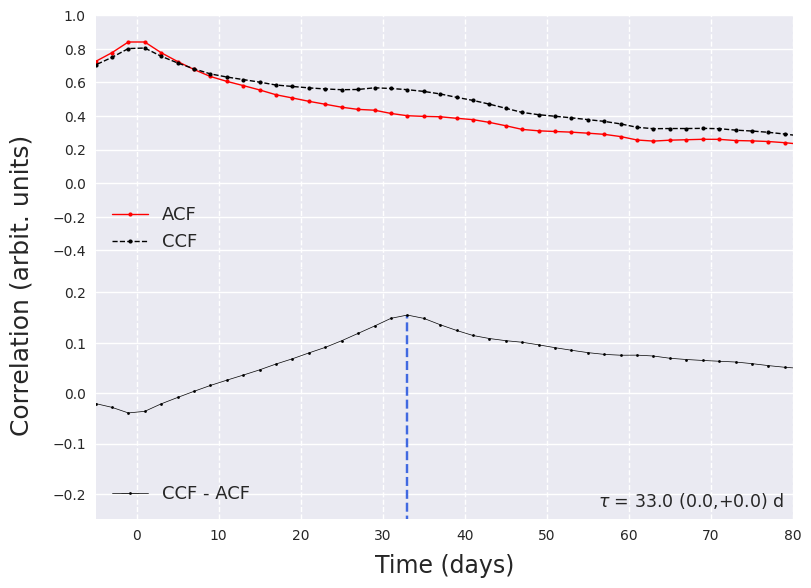

In [14]:
lims_x2 = (-5, 80)
lims_y2 = (-0.5, 1)
err_2 = (err_low_2*(-1), err_high_2)

photRM.plot_ccf_acf(final_ccf_2, ccf_2, acf_2, locator=10, peak=True, tau=tau_2, err=err_2, lims_x=lims_x2, lims_y=lims_y2, )

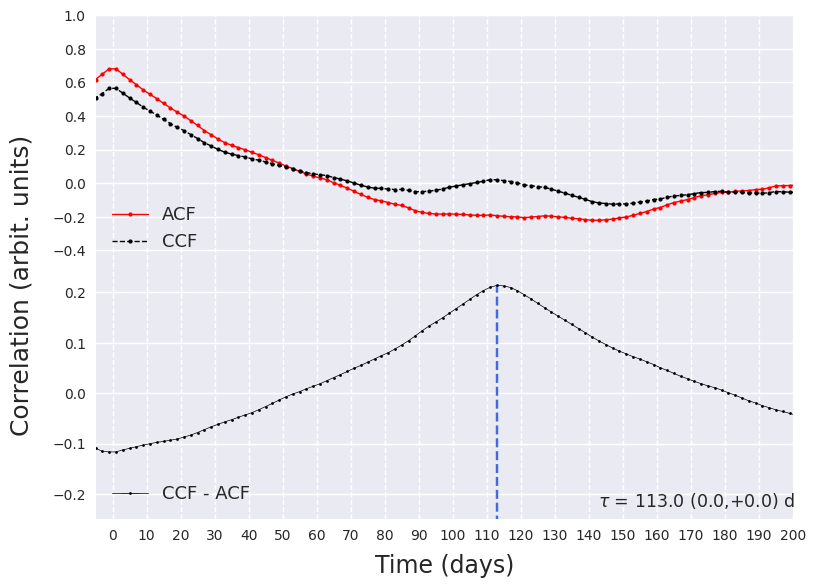

In [15]:
lims_x3 = (-5, 200)
lims_y3 = (-0.5, 1)
err_3 = (err_low_3*(-1), err_high_3)

photRM.plot_ccf_acf(final_ccf_3, ccf_3, acf_3, locator=10, peak=True, tau=tau_3, err=err_3, lims_x=lims_x3, lims_y=lims_y3)

This was pretty successful. Instead 9.8633.65114.82

# Task 2

**Goal:** Apply photometric reverberation mapping to real-world data.

Download photometric light curves of NGC 4395 from Edri et al. (2012). Choose one filter which covers the continuum emission only and the other one that covers the H$\alpha$ emission line and the underlying continuum. Using the utility functions provided, process the data so that time is expressed in hours and line intensity and its error are expressed as normalized flux. Plot the light curves. You will see that they are divided into segments because we have a pause in observations during the daylight. Choose the first segment and estimate the time lag using this data. Compare your results to Edri et al. (2012) and discuss the pros and cons of photometric reverberation mapping compared to spectroscopic reverberation mapping.

In [16]:
# Read the light curves using pd.read_csv()

a = pd.read_csv('obs_data/lc_i.txt', header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2])
b = pd.read_csv('obs_data/lc_r.txt', header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2])

In [17]:
a.head()

,MJD,mag,mag_err
0,2.455616e+06,16.878,0.048
1,2.455616e+06,16.928,0.035
2,2.455616e+06,16.844,0.042
3,2.455616e+06,16.879,0.030
4,2.455616e+06,16.863,0.024


In [18]:
# Light curve processing utility function

from lc_proc import lc_proc
help(lc_proc)

lcs = [a, b]
filters = ['i', 'r'] # see lc_proc docs for accepted values for filters
new_lcs = lc_proc(lcs, filters)

Help on function lc_proc in module lc_proc:

lc_proc(lcs, filters, time='hours')
    Process a list of light curves from Edri et al. (2012). Each light curve 
    is stored as a pandas dataframe.
    
    Parameters:
    -----------
    lcs: list (elements assumed to be pd.DataFrame objects)
        A list of light curves. Each light curve is a pd.DataFrame with columns:
        MJD, mag, mag_err
    filters: str
        Corresponding filter names for light curves (possible vals: 'r', 'g', 'i')
    time: str
        Time unit to convert into. Default is 'hours'.
        
    Returns:
    --------
    lcs: list
        A list of input light curves with added columns: time_hours, flux, 
        flux_err, norm_flux, norm_flux_err



In [19]:
a.head()

,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,2.455616e+06,16.878,0.048,0.00000,983.558056,47.210787,0.430746,0.176837
1,2.455616e+06,16.928,0.035,0.23304,939.290652,32.875173,0.264934,0.123140
2,2.455616e+06,16.844,0.042,0.46536,1014.845663,42.623518,0.547940,0.159655
3,2.455616e+06,16.879,0.030,0.69744,982.652583,29.479577,0.427355,0.110421
4,2.455616e+06,16.863,0.024,0.93000,997.240712,23.933777,0.481997,0.089649


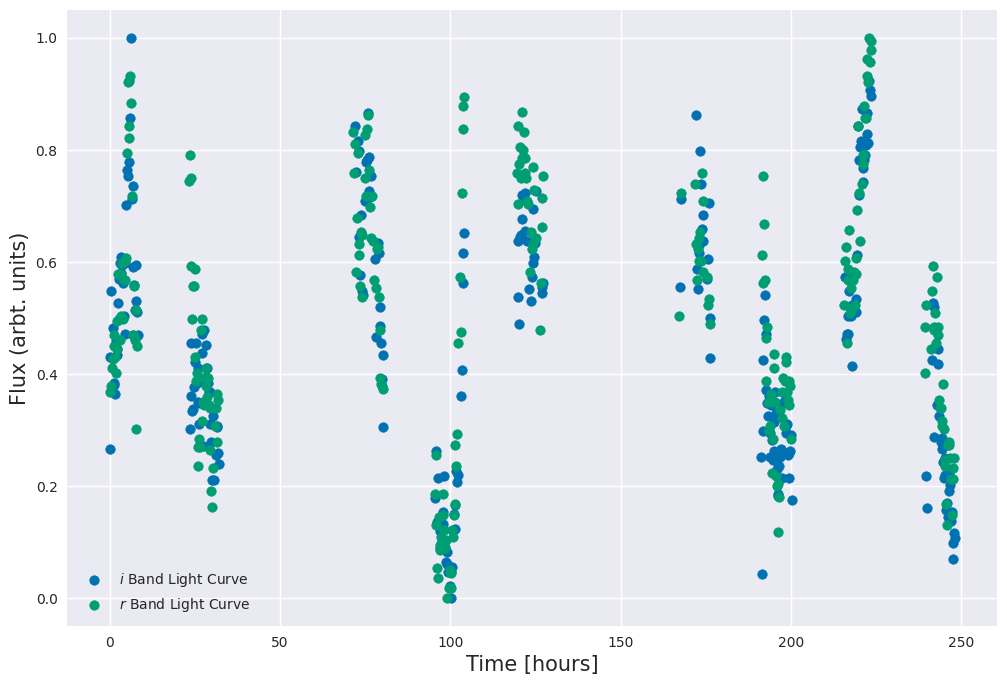

In [20]:
plt.figure(figsize=(12,8))

plt.scatter(a['time_hours'], a['norm_flux'], label='$i$ Band Light Curve')
plt.scatter(b['time_hours'], b['norm_flux'], label='$r$ Band Light Curve')

plt.xlabel('Time [hours]', size=15)
plt.ylabel('Flux (arbt. units)', size=15)

plt.legend()
plt.show()

Cut the data.

In [21]:
a = a[a['time_hours'] < 10]
b = b[b['time_hours'] < 10]

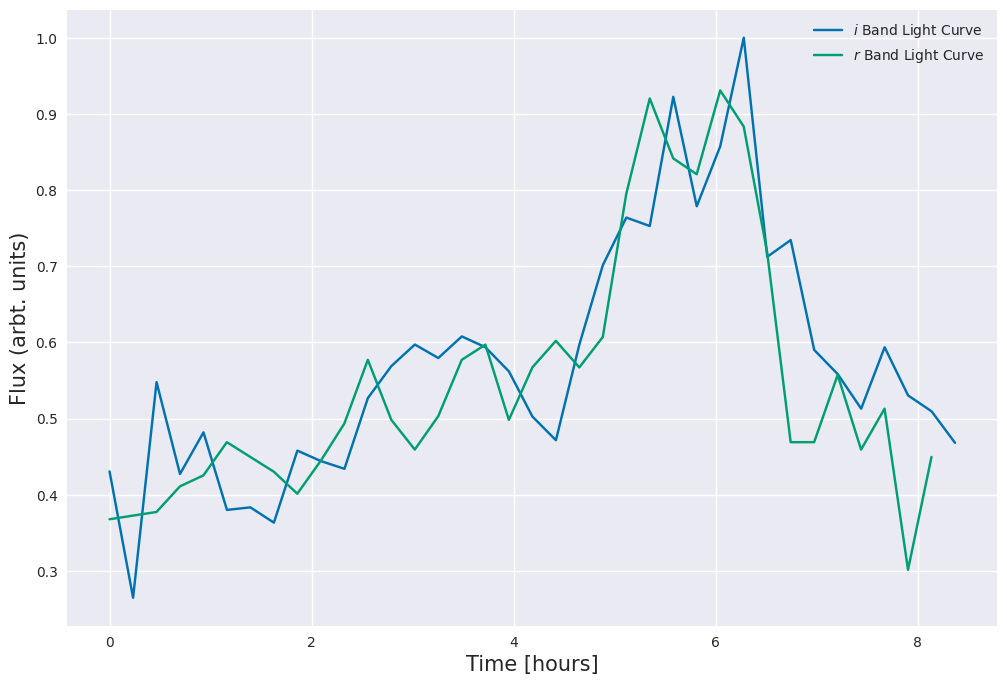

In [22]:
plt.figure(figsize=(12,8))

plt.plot(a['time_hours'], a['norm_flux'], label='$i$ Band Light Curve')
plt.plot(b['time_hours'], b['norm_flux'], label='$r$ Band Light Curve')

plt.xlabel('Time [hours]', size=15)
plt.ylabel('Flux (arbt. units)', size=15)

plt.legend()
plt.show()

In [23]:
# Save the data
dir_path = './data/'

np.savetxt(dir_path+'x_band_edri', np.c_[a['time_hours'].to_numpy(), a['norm_flux'].to_numpy(), a['norm_flux_err'].to_numpy()], fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band_edri', np.c_[b['time_hours'].to_numpy(), b['norm_flux'].to_numpy(), b['norm_flux_err'].to_numpy()], fmt=['%.1f','%.7e','%.7e'])

In [24]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc1 = 'x_band_edri'
lc2 = 'y_band_edri'

In [25]:
# Step 2: ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

35 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.



In [26]:
# Step 3: CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

64 bins actually used, 164 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



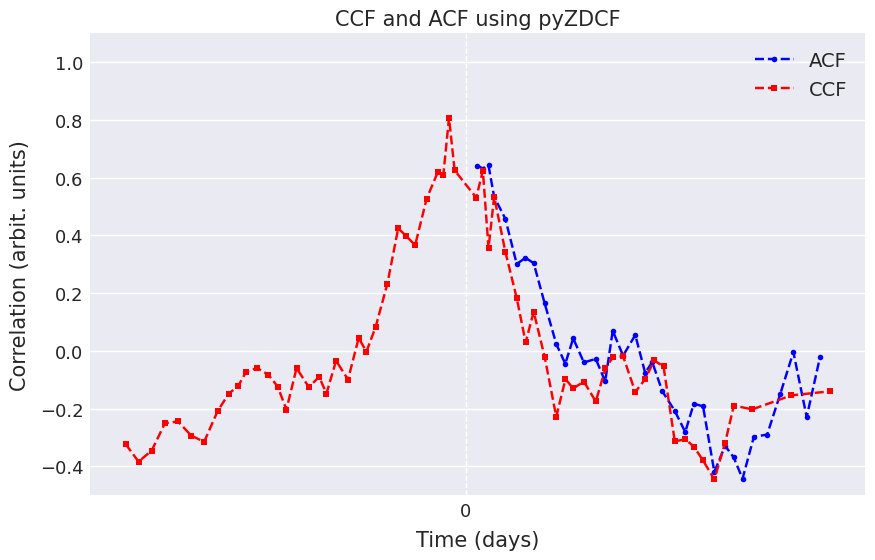

In [27]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf['tau'],acf['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf['tau'],ccf['dcf'],'s--r',label='CCF',markersize=4)

# ax.set_xlim(-120,120)
ax.set_ylim(-0.5,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
# loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [28]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf = photRM.add_inverted_acf(acf)

print('ACF shape: ',acf.shape)
print('CCF shape: ',ccf.shape)

ACF shape:  (70, 7)
CCF shape:  (64, 7)


In [29]:
# We do this by interpolating one of those functions to the time grid of the other.
acf = photRM.interp(ccf,acf) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf.shape)
print('CCF shape: ',ccf.shape)

ACF shape:  (64, 7)
CCF shape:  (64, 7)


In [30]:
# Subtracting CCF and ACF
final_ccf = photRM.delta_ccf(acf, ccf)

In [31]:
final_ccf.tail()

,tau,-sig(tau),+sig(tau),dcf,-err(dcf),+err(dcf),#bin
59,4.590909,0,0,0.024806,0.409189,0.445507,11
60,4.745455,0,0,0.193295,0.413073,0.441326,12
61,5.071429,0,0,0.120009,0.368774,0.388918,15
62,5.763636,0,0,-0.149441,0.454694,0.464727,12
63,6.450000,0,1,-0.662266,0.533358,0.550184,10


In [32]:
tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [0.30000001 0.5        1.20000005 1.76315788 2.0888888  2.47058826
 2.7833333  3.5        3.88461546 4.74545453]
Max. peak:  4.745454528115013


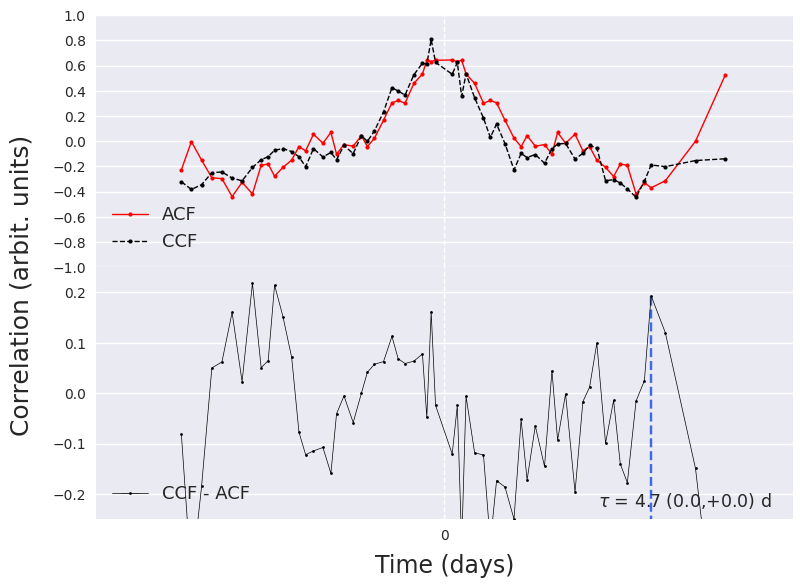

In [33]:
lims_x = (-8,8)
lims_y = (-1,1)
err = (err_low*(-1), err_high)

photRM.plot_ccf_acf(final_ccf,ccf,acf,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x,lims_y=lims_y)

According to the paper, the time delay is 3.6 hours. Our estimate presents the lag to be on the order of 4.7 hours, which is broadly comparable.

Photo reverberation mapping is less observationally time consuming. It can be applied to large scale surveys with more ease then spectroscopic reverberation ampping. In addition, PRB is better for instances where we have a lower S/N, and thus can be usedwith objects of lower size.

SRB remains to be more accurate, especially in the case when certain lines are relatively faint. In these cases, different lines from spectroscopy can be used to estimate time lage to greater success.

# References:

- Edri et al. (2012) https://ui.adsabs.harvard.edu/abs/2012ApJ...756...73E/abstract
- Jankov et al. (2022) https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract
- Kovacevic et al. (2021) https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract
- [Astro Data Lab](https://datalab.noirlab.edu/)
- [pyzdcf documentation](https://pyzdcf.readthedocs.io/en/latest/?badge=latest)
- [PLIKE download link](https://www.weizmann.ac.il/particle/tal/research-activities/software)